# TREC

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gensim.downloader

In [2]:
# Load training and development datasets
df_train=pd.read_csv("../datasets/TREC/train.csv")
df_train["text"] = df_train["text"].str.lower()

# Load test dataset
df_test=pd.read_csv("../datasets/TREC/test.csv")
df_test["text"] = df_test["text"].str.lower()

In [3]:
# Split the training dataset to create a development set of 500 examples
train_data, dev_data = train_test_split(df_train, test_size=500, random_state=42)

# Rename the test dataset to synchronize the namings
test_data = df_test

len(train_data), len(dev_data), len(test_data)

(4952, 500, 500)

## Update Word2Vec

In [4]:
# Download the "glove-twitter-25" embeddings
w2v = gensim.downloader.load('word2vec-google-news-300')

In [5]:
# Out-of-vocabulary (OOV) words
# 1. can be replaced with a special token, such as "<OOV>" or "<UNK>"
# 2. can be ignored

word2idx = w2v.key_to_index

# Add '<UNK>' and '<PAD>' tokens to the vocabulary index
word2idx['<UNK>'] = len(word2idx)
word2idx['<PAD>'] = len(word2idx)

print(f"word2idx['<UNK>']: {word2idx['<UNK>']}")
print(f"word2idx['<PAD>']: {word2idx['<PAD>']}")

word2idx['<UNK>']: 3000000
word2idx['<PAD>']: 3000001


In [6]:
# Add the '<UNK>' word to the vocabulary of the Word2Vec model 
# Initialize it with the average of all word vectors int he pretrained embeddings
unk_vector = np.mean(w2v.vectors, axis=0)
w2v.vectors = np.vstack([w2v.vectors, unk_vector])
print("after insert UNK: ", w2v.vectors.shape)

# Add the '<PAD>' word to the vocabulary of the Word2Vec model 
# Initialize it with a row of zeros in the vectors matrix
w2v.vectors = np.vstack([w2v.vectors, np.zeros(w2v.vectors[0].shape)])
print("after insert UNK: ", w2v.vectors.shape)

after insert UNK:  (3000001, 300)
after insert UNK:  (3000002, 300)


## Modify Class Labels

In [7]:
# Get unique coarse labels
unique_labels = train_data['label-coarse'].unique()

# Randomly select 4 classes
np.random.seed(19260817)
selected_labels = np.random.choice(unique_labels, size=4, replace=False)

# ****** 6 == OTHERS !!!!!! IMPORTANT 
# update: 6 will cause error, change back to OTHERS then transform later

train_data['new_label'] = train_data['label-coarse'].apply(lambda x: x if x in selected_labels else "OTHERS")
dev_data['new_label'] = dev_data['label-coarse'].apply(lambda x: x if x in selected_labels else "OTHERS")
test_data['new_label'] = test_data['label-coarse'].apply(lambda x: x if x in selected_labels else "OTHERS")

# Display the unique labels in the updated training set
train_data['new_label'].unique()

array([2, 0, 'OTHERS', 4, 3], dtype=object)

In [8]:
# Encode labels for easier reference in the following part
label_encoder = LabelEncoder()

test_data['new_label'] = test_data['new_label'].astype(str)
test_data["label_transformed"] = label_encoder.fit_transform(test_data['new_label'])

train_data['new_label'] = train_data['new_label'].astype(str)
train_data["label_transformed"] = label_encoder.fit_transform(train_data['new_label'])

dev_data['new_label'] = dev_data['new_label'].astype(str)
dev_data["label_transformed"] = label_encoder.fit_transform(dev_data['new_label'])

/opt/homebrew/Caskroom/miniforge/base/envs/env_python3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/Caskroom/miniforge/base/envs/env_python3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/Caskroom/miniforge/base/envs/env_python3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/Caskroom/miniforge/base/envs/env_python3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: 

In [9]:
train_data.head()

,label-coarse,label-fine,text,new_label,label_transformed
4943,2,34,what is mikhail gorbachev 's middle initial ?,2,1
2346,0,0,how does the tail affect the flight of a kite ?,0,0
1835,5,21,what were the first three cities to have a pop...,OTHERS,4
4047,1,1,what is the movie jonathan livingstone seagull ?,OTHERS,4
5097,1,23,what is a fear of home surroundings ?,OTHERS,4


In [10]:
dev_data.head()

,label-coarse,label-fine,text,new_label,label_transformed
3408,5,21,what city is served by tempelhol airport ?,OTHERS,4
371,1,2,what is dudley do-right 's horse 's name ?,OTHERS,4
453,0,9,what 's nature 's purpose for tornadoes ?,0,0
290,0,12,what is the history of valentine 's day cards ?,0,0
4457,3,4,what president became chief justice after his ...,3,2


In [11]:
test_data.head()

,label-coarse,label-fine,text,new_label,label_transformed
0,4,40,how far is it from denver to aspen ?,4,3
1,5,21,"what county is modesto , california in ?",OTHERS,4
2,3,12,who was galileo ?,3,2
3,0,7,what is an atom ?,0,0
4,4,8,when did hawaii become a state ?,4,3


## Handle Out of Vocabulary and Pad Sentence (i.e. Add \<UNK> && \<PAD>)

In [12]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

def sentence_to_indices(sentence, vocab):
    return [vocab.get(word, vocab.get('<UNK>')) for word in sentence]

class TRECDataset(Dataset):
    def __init__(self, sentences, labels, vocab):
        self.sentences = [torch.tensor(sentence_to_indices(sentence, vocab)) for sentence in sentences]
        self.labels = [torch.tensor(label) for label in labels]
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]

def collate_fn(batch):
    sentences, labels = zip(*batch)
    sentences_padded = pad_sequence(sentences, batch_first=True, padding_value=word2idx['<PAD>'])
    return sentences_padded, labels

# Create PyTorch datasets and data loaders
train_dataset = TRECDataset(train_data['text'], train_data['label_transformed'], word2idx)
dev_dataset = TRECDataset(dev_data['text'], dev_data['label_transformed'], word2idx)
test_dataset = TRECDataset(test_data['text'], test_data['label_transformed'], word2idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

## Training, Evaluation and Visualization function

**Since Dataloader is fixed, try to use below functions for easy-training-implementation**

In [13]:
from sklearn.metrics import f1_score

In [37]:
def train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer):
    train_losses = []
    dev_losses = []
    train_accuracies = []
    dev_accuracies = []
    y_true = []
    y_pred = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for sentences, label_tuple in train_loader:
            model.zero_grad()
            labels = torch.stack(label_tuple)
            predictions = model(sentences)
            
            loss = loss_function(predictions, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracies.append(100 * correct / total)
        train_losses.append(total_loss/len(train_loader))
        
        # Validation loop
        model.eval()
        dev_loss = 0
        correct_dev = 0
        total_dev = 0
        with torch.no_grad():
            for sentences, label_tuple in dev_loader:
                labels = torch.stack(label_tuple)
                predictions = model(sentences)
                
                loss = loss_function(predictions, labels)
                dev_loss += loss.item()
                
                _, predicted = torch.max(predictions, 1)
                total_dev += labels.size(0)
                correct_dev += (predicted == labels).sum().item()
                
                y_true.extend(labels)
                y_pred.extend(predicted)
                
        dev_accuracies.append(100 * correct_dev / total_dev)
        dev_losses.append(dev_loss/len(dev_loader))
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Dev Loss: {dev_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Dev Accuracy: {dev_accuracies[-1]:.2f}%")
        
        # Compute F1 score
        f1 = f1_score(y_true, y_pred, average='macro')
        print("F1 Score:", f1)

    return train_losses, dev_losses, train_accuracies, dev_accuracies

In [38]:
def evaluate_model(model, test_loader, loss_function):
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    y_true_test = []
    y_pred_test = []
    
    with torch.no_grad():
        for sentences, tag_tuple in test_loader:
            labels = torch.stack(tag_tuple)
            predictions = model(sentences)
            
            loss = loss_function(predictions, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
            y_true_test.extend(labels)
            y_pred_test.extend(predicted)

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # Compute F1 score
    f1_test = f1_score(y_true_test, y_pred_test, average='macro')
    print("F1 Score on Test Set:", f1_test)

    return test_loss, test_accuracy

In [39]:
def visualize(train_losses, dev_losses, train_accuracies, dev_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, dev_losses, 'r*-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, dev_accuracies, 'r*-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Model 1
Hidden layer: Simple linear layer\
Aggregation Method: Average pooling over the word vectors

In [40]:
# Load embedding layer
weights = torch.FloatTensor(w2v.vectors)

# Build nn.Embedding() layer
embedding = nn.Embedding.from_pretrained(weights)
# embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=vocab.get('<PAD>', None), freeze=True)
embedding.requires_grad = False

embedding_matrix = torch.FloatTensor(w2v.vectors)

In [76]:
# Define model 1 architecture
class QuestionClassifierModel1(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(QuestionClassifierModel1, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix,  padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.Linear(embedding_dim, hidden_dim)
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)    # Now, shape: batch_size x seq_length x embedding_dim
        x = self.hidden(x)
        x = torch.relu(x)

        # Aggregation Layer: Averaging word vectors across sequence length
        x = torch.mean(x, dim=1)  # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim
        
        return x

In [77]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
# OUTPUT_DIM = len(label_list)  # Number of unique labels/labels
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5

model = QuestionClassifierModel1(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 150

In [78]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer)

torch.Size([32, 117, 300])
torch.Size([32, 300])
torch.Size([32, 138, 300])
torch.Size([32, 300])
torch.Size([32, 86, 300])
torch.Size([32, 300])
torch.Size([32, 102, 300])
torch.Size([32, 300])
torch.Size([32, 109, 300])
torch.Size([32, 300])
torch.Size([32, 196, 300])
torch.Size([32, 300])
torch.Size([32, 144, 300])
torch.Size([32, 300])
torch.Size([32, 99, 300])
torch.Size([32, 300])
torch.Size([32, 80, 300])
torch.Size([32, 300])
torch.Size([32, 97, 300])
torch.Size([32, 300])
torch.Size([32, 97, 300])
torch.Size([32, 300])
torch.Size([32, 70, 300])
torch.Size([32, 300])
torch.Size([32, 133, 300])
torch.Size([32, 300])
torch.Size([32, 74, 300])
torch.Size([32, 300])
torch.Size([32, 89, 300])
torch.Size([32, 300])
torch.Size([32, 94, 300])
torch.Size([32, 300])
torch.Size([32, 98, 300])
torch.Size([32, 300])
torch.Size([32, 88, 300])
torch.Size([32, 300])
torch.Size([32, 69, 300])
torch.Size([32, 300])
torch.Size([32, 95, 300])
torch.Size([32, 300])
torch.Size([32, 102, 300])
torch.

In [48]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 1.2745, Test Accuracy: 40.20%
F1 Score on Test Set: 0.36272642975351993


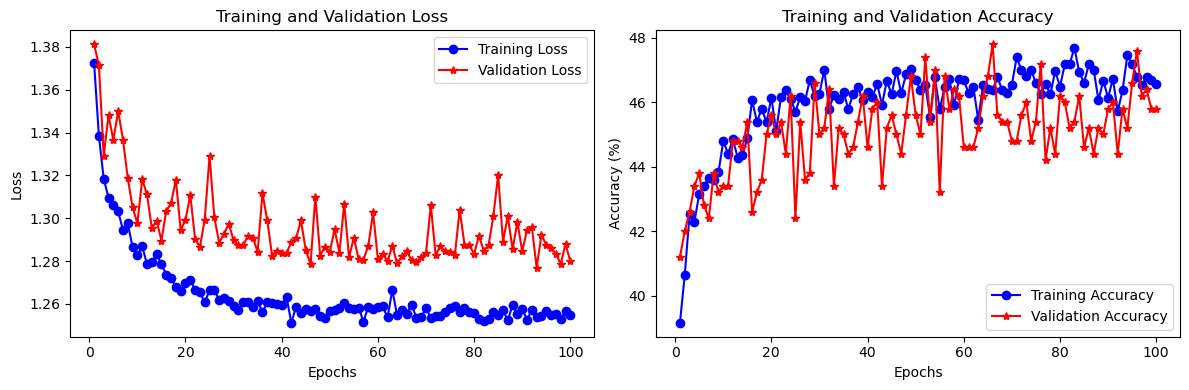

In [49]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

## Model 2
Hidden Layer Design: Simple linear layer\
Aggregation Method: Max pooling over the word vectors

### Intend to do: The max pooling method applied here is basically max-pooling over filters
e.g. \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;\[1,2,3,4\]\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;\[2,0,4,8\]\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;\[9,0,2,1\]\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;|&nbsp;&nbsp;|&nbsp;&nbsp;|\
result: \[9,2,4,8\]
#### To introduce more randomness, we can choose to apply the max-pooling on a portion of randomly selected slots 

### The following implementation is simply doing 1D max pooling over a flattened sentence

In [93]:
# Define model 2 architecture
class QuestionClassifierModel2(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, sample_percent):
        super(QuestionClassifierModel2, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix,  padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.Linear(embedding_dim, hidden_dim)
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
        
        self.sample_percent = sample_percent
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)    # Now, shape: batch_size x seq_length x embedding_dim
        x = self.hidden(x)
        x = torch.relu(x)
        
        # Aggregation Layer: Max pooling over the word vectors
        sentence_len = list(x.size())[1]
        x = torch.flatten(x, start_dim=1)
        max_pooling = nn.MaxPool1d(sentence_len, stride=sentence_len)
        x = max_pooling(x) # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim
        
        return x

In [94]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
# OUTPUT_DIM = len(label_list)  # Number of unique labels/labels
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5
MAX_POOLING_SAMPLE_PERCENT = 0.8

model = QuestionClassifierModel2(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE, MAX_POOLING_SAMPLE_PERCENT)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

In [95]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer)

Epoch 1/100, Train Loss: 1.3716, Dev Loss: 1.3331, Train Accuracy: 39.46%, Dev Accuracy: 43.40%
F1 Score: 0.23097793267131167
Epoch 2/100, Train Loss: 1.2511, Dev Loss: 1.2440, Train Accuracy: 48.99%, Dev Accuracy: 52.60%
F1 Score: 0.31457403262403194
Epoch 3/100, Train Loss: 1.1800, Dev Loss: 1.2020, Train Accuracy: 53.21%, Dev Accuracy: 53.40%
F1 Score: 0.3493986340497218
Epoch 4/100, Train Loss: 1.1368, Dev Loss: 1.1872, Train Accuracy: 55.27%, Dev Accuracy: 55.20%
F1 Score: 0.36653302664073195
Epoch 5/100, Train Loss: 1.1183, Dev Loss: 1.1763, Train Accuracy: 56.48%, Dev Accuracy: 53.00%
F1 Score: 0.3758286725030531
Epoch 6/100, Train Loss: 1.1021, Dev Loss: 1.1571, Train Accuracy: 56.79%, Dev Accuracy: 56.40%
F1 Score: 0.38755439558022864
Epoch 7/100, Train Loss: 1.0873, Dev Loss: 1.1687, Train Accuracy: 57.96%, Dev Accuracy: 56.60%
F1 Score: 0.39061918231175025
Epoch 8/100, Train Loss: 1.0927, Dev Loss: 1.1350, Train Accuracy: 58.06%, Dev Accuracy: 56.40%
F1 Score: 0.392698077548

Epoch 66/100, Train Loss: 0.9891, Dev Loss: 1.0904, Train Accuracy: 62.44%, Dev Accuracy: 59.00%
F1 Score: 0.4546564736055008
Epoch 67/100, Train Loss: 0.9916, Dev Loss: 1.0602, Train Accuracy: 62.64%, Dev Accuracy: 60.60%
F1 Score: 0.4550177010916158
Epoch 68/100, Train Loss: 0.9916, Dev Loss: 1.0691, Train Accuracy: 62.38%, Dev Accuracy: 61.80%
F1 Score: 0.4553888454207254
Epoch 69/100, Train Loss: 1.0051, Dev Loss: 1.0924, Train Accuracy: 62.26%, Dev Accuracy: 60.80%
F1 Score: 0.4553747508259839
Epoch 70/100, Train Loss: 0.9785, Dev Loss: 1.0732, Train Accuracy: 62.50%, Dev Accuracy: 61.00%
F1 Score: 0.45556579782056134
Epoch 71/100, Train Loss: 0.9786, Dev Loss: 1.0672, Train Accuracy: 62.94%, Dev Accuracy: 60.80%
F1 Score: 0.45575833721917036
Epoch 72/100, Train Loss: 0.9924, Dev Loss: 1.0794, Train Accuracy: 61.87%, Dev Accuracy: 61.40%
F1 Score: 0.4558475563801284
Epoch 73/100, Train Loss: 0.9880, Dev Loss: 1.0774, Train Accuracy: 62.06%, Dev Accuracy: 61.20%
F1 Score: 0.4559294

In [96]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 1.1963, Test Accuracy: 49.60%
F1 Score on Test Set: 0.3689854862948937


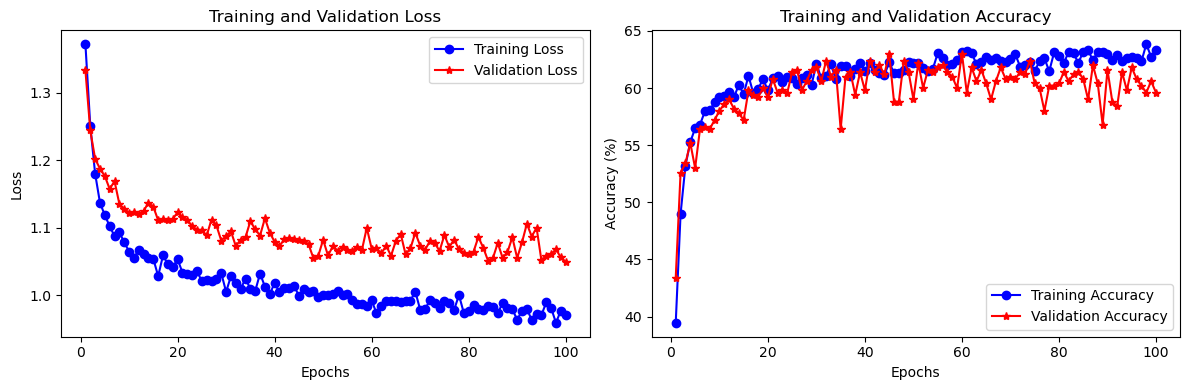

In [97]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

# **Below Code is still Bullshit       :-(**

In [18]:
def get_sentence_embeddings(sentence, model):
    embeddings = []
    for word in sentence.split():
        if word in model:
            embeddings.append(model[word])
        else:
            embeddings.append(np.zeros(300))
    return embeddings

# def embedding(df, model):
#     embeddings_list = []
#     new_labels_list = []
    
#     for index, row in df.iterrows():
#         sentence = row['text']
#         embeddings = get_sentence_embeddings(sentence, model)
        
#         # Appending the embeddings and the corresponding new_label to the lists
#         embeddings_list.append(embeddings)
#         new_labels_list.append(row['new_label'])
    
#     # Creating the new dataframes
#     X_train = pd.DataFrame({'embeddings': embeddings_list})
#     Y_train = pd.DataFrame({'new_label': new_labels_list})
    
#     return X_train, Y_train

def embedding(df, model):
    embeddings_list = []
    new_labels_list = []
    
    for index, row in df.iterrows():
        sentence = row['text']
        embeddings = get_sentence_embeddings(sentence, model)
        
        # Appending the embeddings and the corresponding new_label to the lists
        embeddings_list.append(embeddings)
        new_labels_list.append(row['new_label'])
    
    return embeddings_list, new_labels_list

In [19]:
X_train, Y_train = embedding(train_data, word2idx)
X_dev, Y_dev = embedding(dev_data, word2idx)


## Use a simple linear layer + Averaging all word vectors


In [20]:
import numpy as np

# # Convert object-type DataFrame to list of arrays
# X_train_arrays = list(X_train.apply(lambda x: np.array(x)))

# Stack arrays
X_train_stacked = np.vstack(X_train)

# Convert to PyTorch tensor
X_train_tensor = torch.tensor(X_train_stacked, dtype=torch.float32)


# # Convert object-type DataFrame to list of arrays
# X_test_arrays = list(X_test.apply(lambda x: np.array(x)))

# Stack arrays
X_dev_stacked = np.vstack(X_dev)

# Convert to PyTorch tensor
X_dev_tensor = torch.tensor(X_dev_stacked, dtype=torch.float32)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (8,) + inhomogeneous part.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['new_label'])
y_dev = label_encoder.transform(dev_data['new_label'])

y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
y_dev_tensor = torch.tensor(y_dev, dtype=torch.int64)

In [ ]:
X_train_tensor.shape

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model architecture
class QuestionClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(QuestionClassifier, self).__init__()
        
        # Hidden Layer
        self.hidden = nn.Linear(embedding_dim, hidden_dim)
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x shape: batch_size x seq_length x embedding_dim
        x = self.hidden(x)
        x = torch.relu(x)
        
        # Aggregation Layer: Averaging word vectors across sequence length
        x = torch.mean(x, dim=1)
        
        # Output Layer
        x = self.output(x)
        return x

# Define Hyperparameters
EMBEDDING_DIM = 300  # As each word vector is of shape (300,)
HIDDEN_DIM = 128
OUTPUT_DIM = 5  # 4 integer classes + 1 "OTHERS"
EPOCHS = 100
LR = 0.001

# # Convert dataframes to tensors
# X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.long)
# X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
# Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.long)

# Instantiate the model
model = QuestionClassifier(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    
    optimizer.zero_grad()
    
    predictions = model(X_train_tensor)
    loss = criterion(predictions, Y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:  # Print loss every 10 epochs
        print(f"Epoch: {epoch}/{EPOCHS}, Loss: {loss.item()}")

# Evaluate the model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    _, predicted = test_predictions.max(1)
    accuracy = (predicted == Y_test_tensor).float().mean()
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


In [ ]:
class QuestionClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(QuestionClassifier, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.hidden(x)
        x = torch.mean(x, dim=1)  # Aggregation Layer
        x = self.output(x)
        return nn.functional.softmax(x, dim=1)

In [ ]:
# Hyperparameters
input_dim = 300  # word2vec dimensions
hidden_dim = 128
output_dim = 5  # 5 classes
lr = 0.01

# Model, Loss, Optimizer
model = QuestionClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training
epochs = 1000

train_data = pd.DataFrame()  # Assuming train_data is already loaded as mentioned
dev_data = pd.DataFrame()    # Assuming dev_data is also loaded



In [ ]:
for epoch in range(epochs):
    model.train()
    train_losses = []
    for index, row in train_data.iterrows():
        optimizer.zero_grad()
        sentence = row['text']
        label = row['new_label']

        sentence_embeddings = torch.tensor(get_sentence_embeddings(sentence, glove_vectors)).float().unsqueeze(0)
        
        outputs = model(sentence_embeddings)
        loss = criterion(outputs, torch.tensor([label]).long())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
    model.eval()
    predictions = []
    true_labels = []
    for index, row in dev_data.iterrows():
        sentence = row['text']
        label = row['new_label']
        true_labels.append(label)
        
        with torch.no_grad():
            sentence_embedding = torch.tensor(get_sentence_embedding(sentence, glove_vectors)).float().unsqueeze(0)
            outputs = model(sentence_embedding)
            predicted_class = torch.argmax(outputs).item()
            predictions.append(predicted_class)
            
    dev_accuracy = accuracy_score(true_labels, predictions)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {np.mean(train_losses)}, Dev Accuracy: {dev_accuracy:.2f}")

print("Training complete.")

In [ ]:
# Function to get the average word vector for a sentence
def sentence_vector(sentence):
    words = sentence.split()
    # Split the sentence into words.

    vectors = [glove_vectors[word] for word in words if word in glove_vectors]
    # Get the word vector for each word in the sentence if it exists in glove_vectors.


    if len(vectors) == 0: # to avoid empty lists
        return np.zeros(300)
    # If no words from the sentence are in the word vectors, return a vector of zeros.

    return np.mean(vectors, axis=0)
# Return the average word vector for the sentence.

train_data['avg_vector'] = train_data['text'].apply(sentence_vector)
# Compute the average word vector for each sentence in the training data.

X_train = np.vstack(train_data['avg_vector'].values)
# Stack the average vectors to form the training data.

y_train = pd.get_dummies(train_data['new_label']).values
# Convert the new labels to one-hot encoded vectors.

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# Convert the training data to a PyTorch tensor.

y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.int64)
# Convert the one-hot encoded labels to their corresponding class indices.


In [ ]:
# Neural Network Model with a simple linear layer
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleClassifier, self).__init__()
        # Initialize the parent class.
        
        self.fc = nn.Linear(input_dim, output_dim)
        # Define a fully connected layer.

    def forward(self, x):
        return self.fc(x)
    # Define the forward pass to return the output of the linear layer.

input_dim = 300  # as we're using word2vec-google-news-300
# Define the input dimension based on the word vector size.

output_dim = 5  # for our 5 new classes
# Define the output dimension based on the number of new classes.

model = SimpleClassifier(input_dim, output_dim)
# Initialize the model.

criterion = nn.CrossEntropyLoss()
# Define the loss function (cross entropy).

optimizer = optim.Adam(model.parameters(), lr=0.001)
# Define the optimizer (Adam) with a learning rate.

# Training
epochs = 5000
# Set the number of epochs.

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_train_tensor).float().mean().item()
  


    # Store metrics for visualization
    all_metrics['A']['epochs'].append(epoch)
    all_metrics['A']['accuracy'].append(accuracy)
    all_metrics['A']['loss'].append(loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Accuracy: {accuracy}")
    # Print the loss and accuracy for each epoch.


In [ ]:
visualize_metrics(all_metrics['A'])

## Use a feedforward network which is a combination of a linear transformation and a nonlinear activation function

## Max pooling over the word vectors

In [ ]:
def sentence_vector(sentence):
    words = sentence.split()
    vectors = [glove_vectors[word] for word in words if word in glove_vectors]
    if len(vectors) == 0: # if no words in the sentence have embeddings
        return np.zeros(300)
    return np.max(vectors, axis=0) # max pooling across the words

train_data['maxpooled_vector'] = train_data['text'].apply(sentence_vector)

X_train = np.vstack(train_data['maxpooled_vector'].values)
y_train = pd.get_dummies(train_data['new_label']).values

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.int64)

In [ ]:
train_data.head()

In [ ]:
# Define the neural network model with feedforward layers
class FeedForwardClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForwardClassifier, self).__init__()
        
        # First linear layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        
        # Second linear layer that outputs class probabilities
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Apply first linear transformation
        x = self.fc1(x)
        
        # Apply ReLU activation function
        x = nn.ReLU()(x)
        
        # Apply second linear transformation
        return self.fc2(x)

input_dim = 300  # as we're using word2vec-google-news-300
hidden_dim = 1000  # can be adjusted based on performance
output_dim = 5   # for our 5 new classes

model = FeedForwardClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_train_tensor).float().mean().item()

    # Store metrics for visualization
    all_metrics['B']['epochs'].append(epoch)
    all_metrics['B']['accuracy'].append(accuracy)
    all_metrics['B']['loss'].append(loss.item())
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Accuracy: {accuracy}")


In [ ]:
visualize_metrics(all_metrics['B'])

##  Recurrent neural network
##  Aggregation Layer: Taking the representation of the last word (useful if using RNNs)

In [ ]:
def sentence_matrix(sentence, max_len=30):
    words = sentence.split()[:max_len]  # truncate if necessary
    vectors = [glove_vectors[word] for word in words if word in glove_vectors]
    while len(vectors) < max_len:  # pad if necessary
        vectors.append(np.zeros(300))
    return np.array(vectors)

train_data['vector_matrix'] = train_data['text'].apply(sentence_matrix)

X_train = np.stack(train_data['vector_matrix'].values)
y_train = pd.get_dummies(train_data['new_label']).values

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.int64)

In [ ]:
train_data.head()

In [ ]:
# Define the neural network model with an RNN layer
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNClassifier, self).__init__()
        
        # RNN layer
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        
        # Linear layer that outputs class probabilities
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Pass the input through the RNN layer
        out, _ = self.rnn(x)
        
        # Only take the output from the final timestep
        out = out[:, -1, :]
        
        # Pass the final output through the linear layer
        return self.fc(out)

input_dim = 300  # as we're using word2vec-google-news-300
hidden_dim = 100  # can be adjusted based on performance
output_dim = 5   # for our 5 new classes

model = RNNClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_train_tensor).float().mean().item()

    # Store metrics for visualization
    all_metrics['C']['epochs'].append(epoch)
    all_metrics['C']['accuracy'].append(accuracy)
    all_metrics['C']['loss'].append(loss.item())
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Accuracy: {accuracy}")


In [ ]:
visualize_metrics(all_metrics['C'])